# 0. Import Required Libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn
import h5py
from lib.test import *
from sklearn.metrics import accuracy_score

import mlflow

# 1. Define the CNN architecture

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=21, padding=10)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=15, padding=7)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, padding=5)
        
        self.batchnorm32 = nn.BatchNorm1d(num_features=32)
        self.batchnorm64 = nn.BatchNorm1d(num_features=64)
        self.batchnorm128 = nn.BatchNorm1d(num_features=128)
        self.batchnorm512 = nn.BatchNorm1d(num_features=512)
        
        self.fc1 = nn.Linear(4736, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 2)
        
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)     
        
        self.dropout2d = nn.Dropout2d(p=0.5)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))
        x = F.relu(self.batchnorm32(x))
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = F.relu(self.batchnorm64(x))
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = F.relu(self.batchnorm128(x))
        x = self.maxpool(x)
        
        # Flatten input for fully connected layers
        x = x.view(x.shape[0], -1) 
        
        x = self.dropout(self.fc1(x))
        x = F.relu(self.batchnorm512(x))
        
        x = self.dropout(self.fc2(x))
        x = F.relu(self.batchnorm512(x))
        
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# 2. Load the Data

In [3]:
import h5py

mixdata = h5py.File("../train/scsn_p_2000_2017_6sec_0.5r_pick_train_mix.hdf5", "r")
testdata = h5py.File("../test/scsn_p_2000_2017_6sec_0.5r_pick_test_mix.hdf5", "r")

In [4]:
%%time

from torch.utils.data import DataLoader
from lib.utils import split_trainset

batch_size = 500

train_size = 1 * 10 ** 5
train_ratio = 0.8
test_size = 1 * 10 ** 6

# Load test data
train_val_data = mixdata["X"][:train_size]
train_val_labels = mixdata["pwave"][:train_size]

trainset, valset = split_trainset(train_val_data, train_val_labels, train_ratio)

Wall time: 542 ms


In [5]:
%%time

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)

Wall time: 0 ns


In [6]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"  

In [7]:
model = CNN()

# 3. Add Multi-GPU Support to Model 
In order to run the model on multiple GPU's, we can use the nn.DataParallel layer. This layer requires that we move all tensors to the cuda:0 (the default gpu) before we can pass them through the network. 

In [8]:
def parallelize(model):
    device_ids = [i for i in range(torch.cuda.device_count())]
    model = torch.nn.DataParallel(model, device_ids=device_ids)
    return model

In [9]:
if (device == "cuda"):
    model = parallelize(model)
model

DataParallel(
  (module): CNN(
    (conv1): Conv1d(1, 32, kernel_size=(21,), stride=(1,), padding=(10,))
    (conv2): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (conv3): Conv1d(64, 128, kernel_size=(11,), stride=(1,), padding=(5,))
    (batchnorm32): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm64): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm512): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=4736, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=2, bias=True)
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout2d): Dropout2d(p=0.5)
    (dropout): Dropout(p=0.5)
 

# 4. Define Loss Function and Optimizer
Here we define the loss function and optimizer. For the loss function (criterion), we use the binary cross entropy with logits loss (BCEWithLogitsLoss). This function applies a sigmoid as well as calculates the cross entropy. 

In [10]:
from torch import optim

lr = 0.001

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 5. Training and Validation

In [11]:
mlflow.set_tracking_uri("file:.\mlruns")
mlflow.start_run()

<ActiveRun: info=<RunInfo: run_uuid='74eb699b935b4cc9b4f31339ec5ca170', experiment_id=0, name='', source_type=4, source_name='C:\\Users\\rober\\Miniconda3\\envs\\eew\\lib\\site-packages\\ipykernel_launcher.py', entry_point_name=None, user_id='unknown', status=1, start_time=1553478015213, end_time=None, source_version=None, lifecycle_stage='active', artifact_uri='.\\mlruns\\0\\74eb699b935b4cc9b4f31339ec5ca170\\artifacts'>, data=None>

In [12]:
%%time

epochs = 30

train_losses = []
val_losses = []
val_accuracies = []

val_min = float("inf")

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch, labels in trainloader:
        # ============================================
        #            TRAINING
        # ============================================
        if (device == "cuda"):
            batch, labels = batch.to(device), labels.to(device)
        # Forward pass
        output = model.forward(batch)
        # Clear gradients in optimizer
        optimizer.zero_grad()
        # Calculate loss
        if (device == "cuda"):
            loss = criterion(output, labels.type(torch.cuda.LongTensor).view(labels.shape, 1))
        else:
            loss = criterion(output, labels.type(torch.LongTensor).view(labels.shape, 1))
        train_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
    else:
        with torch.no_grad():
            model.eval()
            val_loss = 0
            
            y_pred = np.array([])
            y_true = np.array([])

            for batch, labels in val_loader:
                # ============================================
                #            VALIDATION
                # ============================================
                if (device == "cuda"):
                    batch, labels = batch.to(device), labels.to(device)
                # Forward pass
                log_probs = model.forward(batch)
                probs = torch.exp(log_probs)
                
                top_p, top_class = probs.topk(1, dim=1)
                y_pred = np.append(y_pred, cuda_to_numpy(top_class))
                y_true = np.append(y_true, cuda_to_numpy(labels))
                
                # Calculate loss
                if (device == "cuda"):
                    loss = criterion(log_probs, labels.type(torch.cuda.LongTensor).view(labels.shape, 1))
                else:
                    loss = criterion(log_probs, labels.type(torch.LongTensor).view(labels.shape, 1))
                val_loss += loss.item()
    
    # Print epoch summary
    t_loss_avg = train_loss / len(trainloader)
    v_loss_avg = val_loss / len(val_loader)
    accuracy = accuracy_score(y_true, y_pred)
    
    if v_loss_avg < val_min:
        torch.save(model.state_dict(), "./artifacts/model.pth")
        val_min = v_loss_avg
    
    mlflow.log_metric("train_loss", t_loss_avg)
    mlflow.log_metric("val_loss", v_loss_avg)
    mlflow.log_metric("val_accuracy", accuracy)
    
    train_losses.append(t_loss_avg)
    val_losses.append(v_loss_avg)
    val_accuracies.append(accuracy)
    
    print('Epoch [{:5d}/{:5d}] | train loss: {:6.4f} | validation loss: {:6.4f} | validation accuracy: {:6.4f}%'.format(
            epoch+1, epochs, t_loss_avg, v_loss_avg, accuracy * 100))

Epoch [    1/   30] | train loss: 0.0717 | validation loss: 0.2030 | validation accuracy: 98.1850%
Epoch [    2/   30] | train loss: 0.0465 | validation loss: 0.2145 | validation accuracy: 98.8150%
Epoch [    3/   30] | train loss: 0.0403 | validation loss: 0.1873 | validation accuracy: 98.9150%
Epoch [    4/   30] | train loss: 0.0369 | validation loss: 0.1439 | validation accuracy: 98.8850%
Epoch [    5/   30] | train loss: 0.0325 | validation loss: 0.1438 | validation accuracy: 98.9600%
Epoch [    6/   30] | train loss: 0.0296 | validation loss: 0.1628 | validation accuracy: 98.7250%
Epoch [    7/   30] | train loss: 0.0262 | validation loss: 0.1050 | validation accuracy: 98.9800%
Epoch [    8/   30] | train loss: 0.0232 | validation loss: 0.0961 | validation accuracy: 98.9000%
Epoch [    9/   30] | train loss: 0.0196 | validation loss: 0.0747 | validation accuracy: 98.7000%
Epoch [   10/   30] | train loss: 0.0173 | validation loss: 0.1328 | validation accuracy: 98.5100%
Epoch [   

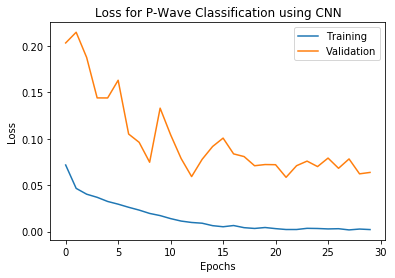

In [13]:
# add learning curve plot
train_loss = np.array(train_loss)

plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for P-Wave Classification using CNN")
plt.legend()

Text(0.5, 1.0, 'Validation Accuracy for P-Wave Classification using CNN')

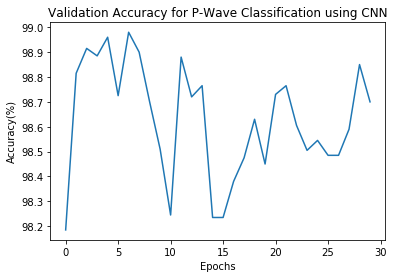

In [14]:
plt.plot([i * 100 for i in val_accuracies])
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.title("Validation Accuracy for P-Wave Classification using CNN")

# 6. Testing Model Performance

For testing model performance, we'll be using scikit learn's metrics library. Scikit learn provides a handful of builtin classfication metrics which we can take advantage of. In order to use them with pytorch, we'll have to move the tensors from GPU to CPU and convert them to numpy arrays. 

1. Classification Report  
    a. Precision  
    b. Recall  
    c. F1 Score
2. Accuracy
3. AUC-ROC

In [15]:
%%time

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

model.load_state_dict(torch.load("./artifacts/model.pth"))

test_path = "../test/scsn_p_2000_2017_6sec_0.5r_pick_test_mix.hdf5"

y_true, y_pred, y_probs = test_model(model, test_path, test_size, device="cuda")

report = classification_report(y_true, y_pred, target_names=["pwave", "noise"])
report_dict = classification_report(y_true, y_pred, target_names=["pwave", "noise"], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)
roc_auc_score = roc_auc_score(y_true, y_probs)

print(report)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("ROC Score: ", roc_auc_score)

              precision    recall  f1-score   support

       pwave       1.00      0.98      0.99    500000
       noise       0.98      1.00      0.99    500000

   micro avg       0.99      0.99      0.99   1000000
   macro avg       0.99      0.99      0.99   1000000
weighted avg       0.99      0.99      0.99   1000000

Accuracy: 98.81%
ROC Score:  0.9680230463060002
Wall time: 2min 24s


In [16]:
mlflow.log_param("epochs", epochs)
mlflow.log_param("learning_rate", lr)
mlflow.log_param("device", device)
mlflow.log_param("train_val_split", train_ratio)

mlflow.log_artifact("./artifacts/model.pth")

mlflow.log_metric("accuracy", accuracy)
for category in report_dict:
    for metric, value in report_dict[category].items():
        metric_name = category + "_" + metric
        mlflow.log_metric(metric_name, value)
        
mlflow.end_run()

# References

1. https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2017JB015251
2. http://scedc.caltech.edu/research-tools/deeplearning.html#picking_polarity